# Howso Enterprise Data Synthesis Workflow

This notebook will provide a high level overview of the synthetic data generation process, including the final data evaluation for accuracy vs. privacy trade off. More details on each data generation step will be covered in subsequent notebooks.

The process can be broken down into six key steps as illustrated in the diagram below.

<img src="static/synthesizer_process_workflow.png" width="1080">

> ⚠ — `Howso Enterprise` and this recipe require `pyspark` to be installed. In order to conform to as many environments
> as possible, it is not installed automatically.
>
> To install it, run `python -m pip install pyspark<4.0`
> in your Python environment.

## Step 1: Load Data

In [1]:
from pathlib import Path

from IPython.display import (
    display,
    Markdown,
)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from howso.enterprise import Howso, infer_feature_attributes

In [2]:
data_path = Path("/home", "sagemaker-user", "phs002525", "rad_015_941-01_deidentified_clinicaldata_DATA_origcopy_v1.csv")
df = pd.read_csv(data_path)
df = df.reset_index(drop=True)
print(df.columns)
print(f'total number of rows: {len(df)}')

Index(['study_id', 'race', 'ethnicity', 'age', 'sex', 'zip', 'insurance',
       'vaping', 'nicotine', 'alcohol_use', 'asthma', 'cancer',
       'cardiovascular_disease', 'chronic_kidney_disease',
       'chronic_lung_disease', 'diabetes', 'hypertension',
       'immunosuppressive_conditio', 'serious_mental_illness',
       'sickle_cell_disease', 'pregnancy_status', 'height_feet',
       'height_inches', 'weight_lbs', 'patient_data_date',
       'patient_covid_test_complete', 'covid_test_result', 'covid_test_type',
       'patient_stay_length', 'patient_ventilator', 'patient_icu',
       'patient_remdesivir_use', 'patient_mortality', 'country'],
      dtype='object')
total number of rows: 8123


## Step 2: Map Data

Confirm the data types are detected correctly.


In [3]:
features = infer_feature_attributes(df, attempt_infer_extended_nominals=True,
                                    datetime_feature_formats={"patient_data_date": "%m/%d/%Y"},
                                    types={"continuous": ["age"]})

# As this is just a recipe notebook and not an attempt at creating anonymous data, we are setting the nominal features
# as `non_sensitive`. When creating anonymous data, you should only set nominal features as non-sensitive if they are
# truly non-sensitive. For example, when attempting to create anonymous data, we strongly recommend that nominals are
# encoded, which can be achieved by the following utility code:
# features = infer_features_attributes(df_orig, attempt_infer_extended_nominals=True)
# print(f'inferred type of age column: {features["age"]["type"]}')
# features["age"]["type"] = "continuous"
features["race"]["type"] = "nominal"
features["race"]["subtype"] = "integer"
features["study_id"]["subtype"] = "uuid"
features["ethnicity"]["subtype"] = "integer"
features["sex"]["subtype"] = "integer"
features["zip"]["type"] = "nominal"
features["zip"]["subtype"] = "postcode"
features["patient_data_date"]["type"] = "continuous"

features.to_dataframe()

/home/sagemaker-user/venv/lib/python3.12/site-packages/howso/utilities/feature_attributes/base.py:1187: UserWarning: The provided or inferred `date_time_formats` for the following features do not include a time zone and will default to UTC:
	- patient_data_date
To change the default time zone, please specify the `default_time_zone` argument to `infer_feature_attributes`.
  warnings.warn(msg)


type date_time_format decimal_places  \
                                                                          
study_id                        nominal              NaN            NaN   
race                            nominal              NaN            0.0   
ethnicity                       nominal              NaN            NaN   
age                          continuous              NaN            0.0   
sex                             nominal              NaN            0.0   
zip                             nominal              NaN            0.0   
insurance                       nominal              NaN            0.0   
vaping                          nominal              NaN            0.0   
nicotine                        nominal              NaN            0.0   
alcohol_use                     nominal              NaN            0.0   
asthma                          nominal              NaN            0.0   
cancer                          nominal              NaN            0.0   
cardiovascular_disease          nominal              NaN            0.0   
chronic_kidney_disease          nominal              NaN            0.0   
chronic_lung_disease            nominal              NaN            0.0   
diabetes                        nominal              NaN            0.0   
hypertension                    nominal              NaN            0.0   
immunosuppressive_conditio      nominal              NaN            0.0   
serious_mental_illness          nominal              NaN            0.0   
sickle_cell_disease             nominal              NaN            0.0   
pregnancy_status                nominal              NaN            0.0   
height_feet                  continuous              NaN            0.0   
height_inches                continuous              NaN            0.0   
weight_lbs                   continuous              NaN            0.0   
patient_data_date            continuous         %m/%d/%Y            NaN   
patient_covid_test_complete     nominal              NaN            NaN   
covid_test_result               nominal              NaN            0.0   
covid_test_type                 nominal              NaN            0.0   
patient_stay_length          continuous              NaN            0.0   
patient_ventilator              nominal              NaN            NaN   
patient_icu                     nominal              NaN            NaN   
patient_remdesivir_use          nominal              NaN            NaN   
patient_mortality               nominal              NaN            NaN   
country                         nominal              NaN            NaN   

                                bounds                                       \
                            allow_null         min         max observed_min   
study_id                          True         NaN         NaN          NaN   
race                              True           0         9.0          1.0   
ethnicity                         True         NaN         NaN          NaN   
age                              False           0        90.0         21.0   
sex                              False         NaN         NaN          NaN   
zip                               True           0      1577.0        100.0   
insurance                        False         NaN         NaN          NaN   
vaping                           False         NaN         NaN          NaN   
nicotine                         False         NaN         NaN          NaN   
alcohol_use                      False         NaN         NaN          NaN   
asthma                           False         NaN         NaN          NaN   
cancer                           False         NaN         NaN          NaN   
cardiovascular_disease           False         NaN         NaN          NaN   
chronic_kidney_disease           False         NaN         NaN          NaN   
chronic_lung_disease             False         NaN         NaN        

## Step 3: Set Desired Parameters

- Desired parameter: Synthesizer allows the user to tune synthetic data based on privacy / accuracy requirements, this notebook will use the default settings which provides a good balance between accuracy and privacy


## Step 4-6: Characterize Data, Generate New Data, Analyze Data

> ⚠ Note: To parameterize synthesis using epsilon (differential privacy), use the `epsilon_upper_bound` parameter to `Howso.synthesize()`
> instead of `desired_conviction`. Validator's `AnonymityPreservation` measures epsilon post-synthesis by accessing the average distance between each synthetic point and its nearest original record, which may be used to validate that the empirical epsilon is below `epsilon_upper_bound`.

- Characterize Data: Synthesizer preserves the distribution in the original dataset by default and cross-shreds the original data so there will not be a 1-to-1 mapping to the original dataset to maintain privacy. 

- Analyze Data: Validator uses the same Trainee as Synthesizer to analyze the quality _and_ privacy of the synthesis.

- Characterizing, generating, and analyzing new synthetic data with Synthesizer & Validator using the parameters described above is as simple as:


In [4]:
tests_to_run = [
    "AnonymityPreservation",
    "DescriptiveStatistics",
    "JointProbability",
    "ModelComparison",
    # FeatureImportanceComparison is expensive and you should consider disabling it for large datasets,
    # particularly datasets with many features.
    "FeatureImportanceComparison",
]

# Instantiate our compute environment. In this case it is Howso Standalone running on a local machine.
with Howso() as howso:
    results = howso.synthesize(
        # Perform the synthesis, with validation
        source_data=df,
        features=features,
        validate_options={"metrics": tests_to_run},
    )

display(results.destination_data.get_dataframe())


Version 48.2.1 of Howso Engine™ is available. You are using version 45.0.6.
/home/sagemaker-user/venv/lib/python3.12/site-packages/howso/utilities/feature_attributes/base.py:1187: UserWarning: The provided or inferred `date_time_formats` for the following features do not include a time zone and will default to UTC:
	- patient_data_date
To change the default time zone, please specify the `default_time_zone` argument to `infer_feature_attributes`.
  warnings.warn(msg)


Train chunk «synthesized_data:chunk-1» with 8,123 samples took 0:00:00.693864.
Analyze chunk «synthesized_data:chunk-1» with 8,123 samples took 0:00:24.624358.


/home/sagemaker-user/venv/lib/python3.12/site-packages/howso/nominal_substitution/substitution_engine.py:205: UserWarning: Neither the system locale (C) or the configured locale(s) [] are available in Faker. (https://faker.readthedocs.io/en/master/locales.html) Locale for Faker will be set to en_US.
  warnings.warn(
/home/sagemaker-user/venv/lib/python3.12/site-packages/howso/nominal_substitution/substitution_engine.py:713: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9426' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  cases.loc[index] = self.generate_row(case)
/home/sagemaker-user/venv/lib/python3.12/site-packages/howso/nominal_substitution/substitution_engine.py:713: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4773' has dtype incompatible with float64, please explicitly cas

Synthesize chunk «synthesized_data:chunk-1» with 8,123 samples took 0:00:41.139389.
Validate chunk «synthesized_data:chunk-1» with 8,123 samples took 0:01:08.590568.
Validator desirability results of chunk «synthesized_data:chunk-1»: AnonymityPreservation: 5.0 | DescriptiveStatistics: 4.796 | JointProbability: 1.505 | ModelComparison: 4.624 | FeatureImportanceComparison: 3.137
Processing complete.
Synthesizing DataFrameData8778548121857 to /home/sagemaker-user/synthesized_data.csv via chunks of 25,000 samples with 1 workers required 0:02:17.838224.
Wall clock: 0:02:17.838224 (102.1%), Train: 0:00:00.693864 (0.5%), 
Analyze: 0:00:24.624358 (18.2%), 
Synthesis: 0:00:41.139389 (30.5%), 
Validation: 0:01:08.590568 (50.8%), Total CPU: 0:02:15.048179.


,study_id,race,ethnicity,age,sex,zip,insurance,vaping,nicotine,alcohol_use,...,patient_data_date,patient_covid_test_complete,covid_test_result,covid_test_type,patient_stay_length,patient_ventilator,patient_icu,patient_remdesivir_use,patient_mortality,country
0,7813f93f-a762-40ff-a02a-b7f1de1e69a3,9426,4773,77,5236,71126,6988374377360167223,93656624202949415,3340223164620921451,1697026619532915263,...,03/19/2021,709883477075222503,1243927858348656271,1357693883912703016,9.0,6497005937992969398,5439921796994086839,1450284997882157685,6716107256247865178,4808628779505246701
1,a89a33c3-cb55-4ee9-bacd-a523cfc1c1a3,490,4773,74,5773,71126,7407379478497258842,93656624202949415,3340223164620921451,1697026619532915263,...,12/05/2022,709883477075222503,1243927858348656271,1357693883912703016,NaN,6497005937992969398,5439921796994086839,1605865705425599981,6716107256247865178,4808628779505246701
2,6d1a058e-11bb-40d4-b217-a001ee835eab,490,4773,66,5236,13490,7407379478497258842,93656624202949415,3340223164620921451,1697026619532915263,...,12/26/2021,709883477075222503,1243927858348656271,1357693883912703016,8.0,6497005937992969398,5439921796994086839,1605865705425599981,6716107256247865178,4808628779505246701
3,972b410f-ee0b-43b6-9626-cdd07d7a2533,490,4773,55,5773,14131,6988374377360167223,93656624202949415,5943729043640679354,1697026619532915263,...,09/16/2022,709883477075222503,1243927858348656271,1357693883912703016,0.0,6497005937992969398,5439921796994086839,1605865705425599981,6716107256247865178,4808628779505246701
4,6b8b4f59-dd87-4018-aa8d-cda2a3be16b2,490,4773,59,5236,71126,7407379478497258842,93656624202949415,3340223164620921451,1697026619532915263,...,03/14/2020,709883477075222503,1243927858348656271,1357693883912703016,0.0,6497005937992969398,5439921796994086839,1605865705425599981,6716107256247865178,4808628779505246701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,c39a121b-bf73-45fd-84c1-e33c7abc6846,490,4773,80,5773,71126,7407379478497258842,93656624202949415,5943729043640679354,1697026619532915263,...,11/27/2022,709883477075222503,1243927858348656271,1357693883912703016,NaN,6497005937992969398,8027845852706710927,1450284997882157685,6716107256247865178,4808628779505246701
8119,561129d5-f682-4cce-acd2-fd9276143b27,490,4773,77,5773,71126,7407379478497258842,93656624202949415,3340223164620921451,1697026619532915263,...,07/12/2022,709883477075222503,1243927858348656271,1357693883912703016,NaN,6497005937992969398,5439921796994086839,1605865705425599981,6716107256247865178,4808628779505246701
8120,cc1e1275-c8b1-49ec-8731-a2f86bb3872b,490,4773,59,5773,71126,7407379478497258842,93656624202949415,5943729043640679354,1697026619532915263,...,07/03/2020,709883477075222503,1243927858348656271,1357693883912703016,12.0,6497005937992969398,5439921796994086839,1450284997882157685,6716107256247865178,4808628779505246701
8121,739971aa-9217-4223-9345-033de9d142ef,490,4773,47,5773,71126,7407379478497258842,93656624202949415,5943729043640679354,1697026619532915263,...,07/14/2020,709883477075222503,1243927858348656271,1357693883912703016,0.0,7182532412763812408,5439921796994086839,1605865705425599981,6716107256247865178,4808628779505246701


### Step 6.1: Inspect results

For the data set we will do a simple visual comparison and calculate the descriptive statistics along with classification accuracy between the original vs. the synthesized data to determine the quality of synthesis

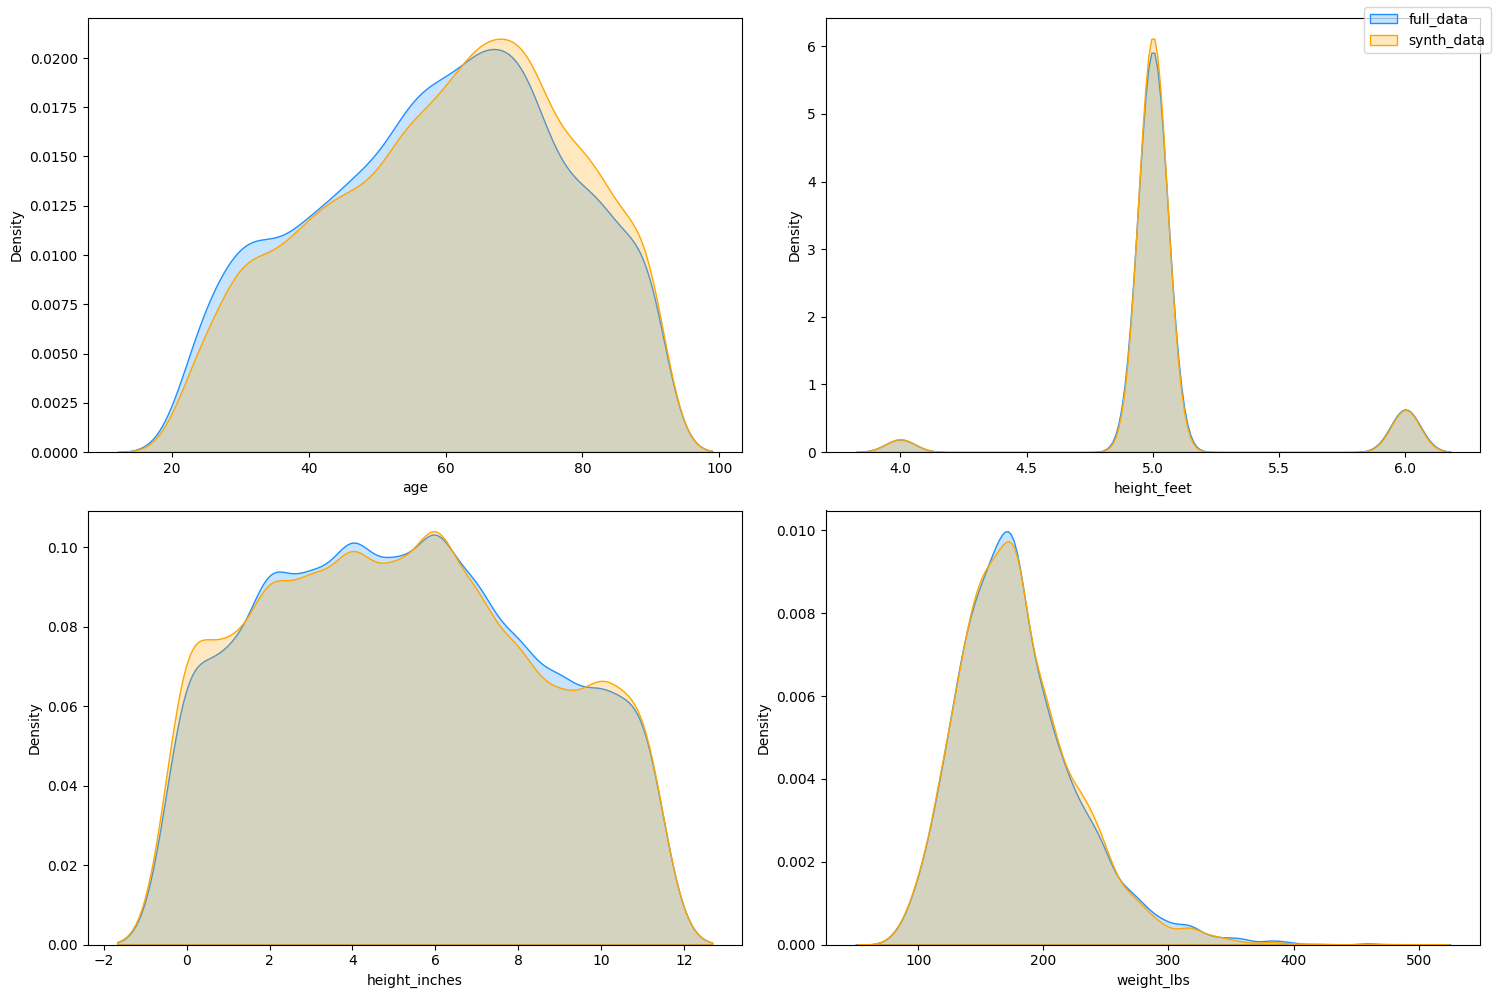

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
categorical_features = [f for f, a in features.items() if a["type"] in ("nominal", "ordinal")]

for c, ax in zip(df.columns.drop(categorical_features), axes.flat):
    sns.kdeplot(ax=ax, x=df[c], color="dodgerblue", label="full_data", fill=True)
    sns.kdeplot(ax=ax, x=results.destination_data.get_dataframe()[c], color="orange", label="full_data", fill=True)
    ax.set_xlabel(c)

fig.legend(labels=["full_data", "synth_data"])
fig.tight_layout()
plt.show()

In [6]:
for name, result in sorted(results.validate_results.items()):
    display(Markdown(f"### {name} - Desirability: {result.desirability}"))
    display(Markdown(result.description))
    display(result.get_df())

### AnonymityPreservation - Desirability: 5.0

Measure how well the generated data preserve the privacy of the original data by comparing the distance from each generated case to its nearest original neighbor. This distance is divided by the smallest or average distance in that original neighbor's region, acting as a proxy for density called the distance ratio. If this ratio is at least 1, then privacy is maintained. If this ratio is at least 0.5, then plausible deniability is maintained. Desirability is computed on the worst case by default, with a desirability of 5 corresponding to a minimum distance ratio of 1 or greater. Also of note is the measured epsilon portion of the results. In differential privacy, this indicates the amount of the privacy budget that was actually consumed during synthesis. The total privacy budget is indicated by the `epsilon_upper_bound` parameter to `Synthesizer.synthesize_cases`, if specified.

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1.0,"(0.049787068367863944, 5, 20)",1.0,min,36971.04037,1.640153,1.034376,5.0


### DescriptiveStatistics - Desirability: 4.796

Shows differences in `basic statistics` between the features of the original and generated data.

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1.0,original,covid_test_result,mode,1.0,5.000000
1,1.0,generated,covid_test_result,mode,1243927858348656384.0,5.000000
2,1.0,original,covid_test_result,entropy,0.0,5.000000
3,1.0,generated,covid_test_result,entropy,0.0,5.000000
4,1.0,original,covid_test_result,uniques,1.0,5.000000
...,...,...,...,...,...,...
253,1.0,generated,weight_lbs,kurtosis,5.159829,4.953065
254,1.0,original,weight_lbs,median,173.0,4.953065
255,1.0,generated,weight_lbs,median,173.0,4.953065
256,1.0,original,weight_lbs,max,500.0,4.953065


### FeatureImportanceComparison - Desirability: 3.137

Builds and trains Trainees using original and generated data to compute Feature Robust Accuracy Contributions and Feature Robust Prediction Contributions. The feature importance rankings of the original and generated data are then compared using Rank-Biased Overlap (RBO) and Wasserstein Distance, also called Earth-Mover Distance (EMD), statistical methods. The geometric mean of the scaled RBO and EMD statistics is used as the desirability score. A desirability near 5 represents near similar feature importance rankings, desirability in the 4-3 range represents minor shuffling of important features, and a desirability of 2 or less represents the major shuffling of important features. Using the test_data argument can be used to give more accurate estimates by holding out data from both the original and the process used to generate data. However, by holding out test data from the data generation process, the generated data may be less accurate. The actual accuracy loss is expectation between the accuracy loss measured with and without using holdout test_data.

,run_number,action_feature,feature_importance_type,measure,measure_value,desirability
0,1.0,height_feet,ac,rbo,0.911458,4.826
1,1.0,height_feet,pc,rbo,0.968750,5.000
2,1.0,height_feet,ac,wasserstein,0.006700,4.987
3,1.0,height_feet,pc,wasserstein,0.010600,5.000
4,1.0,patient_stay_length,ac,rbo,0.786458,4.215
5,1.0,patient_stay_length,pc,rbo,0.968750,5.000
6,1.0,patient_stay_length,ac,wasserstein,0.173337,4.353
7,1.0,patient_stay_length,pc,wasserstein,0.082400,5.000
8,1.0,patient_data_date,ac,rbo,0.161458,2.162
9,1.0,patient_data_date,pc,rbo,0.968750,5.000


### JointProbability - Desirability: 1.505

Measure how well the generated data capture the joint distribution of the original data by estimating the PDF of the data and computing the Jensen-Shannon divergence between both estimates.

,run_number,k,p,js,desirability
0,1.0,"[0.049787068367863944, 5, 20]",1.0,0.699071,1.505


### ModelComparison - Desirability: 4.624

Measure how well the generated data can act as a substitute for the original data by comparing model performance. Specifically, trains one model on a training set of the original data and one model on a training set of the generated data and evaluates them both against a test set of the original data. Desirability goes towards 5 as the performance becomes more similar. Degradations in performance of the generated model (e.g., lower accuracy) are punished more harshly than improvements in performance.

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1.0,original,Howso,height_feet,mae,0.092271,4.434000
1,1.0,generated,Howso,height_feet,mae,0.083035,4.434000
2,1.0,original,Howso,height_feet,spearman,0.696599,4.974000
3,1.0,generated,Howso,height_feet,spearman,0.699840,4.974000
4,1.0,original,Howso,height_feet,r2,0.145531,4.798920
5,1.0,generated,Howso,height_feet,r2,0.241715,4.798920
6,1.0,original,Howso,height_feet,rmse,0.286435,4.653000
7,1.0,generated,Howso,height_feet,rmse,0.269833,4.653000
8,1.0,original,Howso,patient_stay_length,mae,5.599383,4.617000
9,1.0,generated,Howso,patient_stay_length,mae,5.987677,4.617000
